In [1]:
# Import necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from ast import literal_eval
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score 
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import timeit
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [2]:
#Load train document
train=pd.read_csv('data/train_clean.csv', na_values='Unknown')
print(train.head())

                                           msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
1  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
2  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
3  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
4  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   

                                        song_id source_system_tab  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   
1  bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=        my library   
2  JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=        my library   
3  2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=        my library   
4  3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=           explore   

    source_screen_name      source_type  target  
0              explore  online-playlist       1  
1  local playlist more   local-playlist       1  
2  local playlist more   local-playlist       1  
3  local playlist more   local-playlist       1  
4              explore  onli

In [3]:
#Check amount of NaN in train.csv by column
train.isnull().sum()

msno                       0
song_id                    0
source_system_tab          0
source_screen_name    444107
source_type                0
target                     0
dtype: int64

In [4]:
train.shape

(7349234, 6)

In [5]:
# Replace Nan by -1
train=train.fillna(-1)

# Convert variables to category
for item in ['source_system_tab','source_screen_name','source_type']:
    train[item]=train[item].astype('category')

In [6]:
#Compute total unique songs listened by user
users_total_songs=train.groupby('msno').msno.count().to_frame()
users_total_songs.columns=['song_count']

# Join songs count to train data
train=pd.merge(train,users_total_songs,left_on='msno',right_index=True)
train.head()

msno  \
0     FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
4     FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
5     FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
7     FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
6707  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   

                                           song_id source_system_tab  \
0     BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   
4     3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=           explore   
5     3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=           explore   
7     bPIvRTzfHxH5LgHrStll+tYwSQNVV8PySgA3M1PfTgc=           explore   
6707  XUz4Z4wPPChz+OIwkwj7HJ8teIjW3rEMdEATM80rDxM=           explore   

     source_screen_name      source_type  target  song_count  
0               explore  online-playlist       1        5511  
4               explore  online-playlist       1        5511  
5               explore  online-playlist       1        5511  
7               explore  online-playlist       1        5511  
6707            explore  online-playlist       1        5511

In an attempt to sub-sample the dataset to reduce the volumen, we will check if there are many users who have listened few songs so we can just keep the users with higher number of songs listened. This will increase the possibilities to find these users both in the train and test samples after splitting the data.

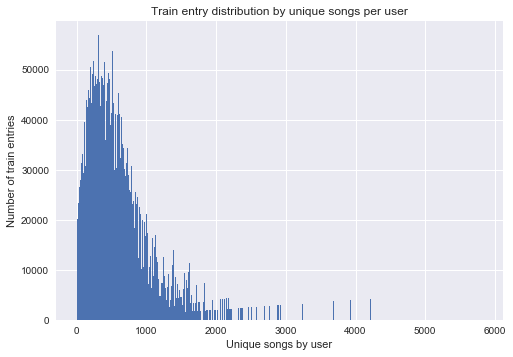

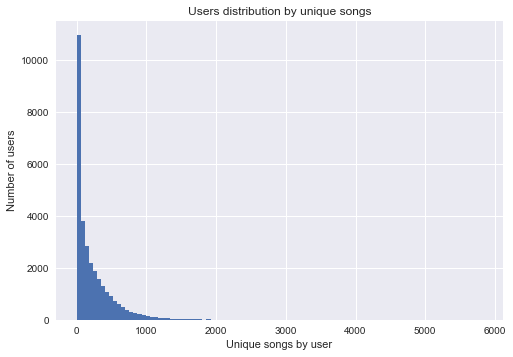

In [7]:
# Plot histogram of train entries by unique songs by user
plt.hist(train.song_count, bins=1000)
plt.ylabel('Number of train entries')
plt.xlabel('Unique songs by user')
plt.title('Train entry distribution by unique songs per user')
plt.show()

# Plot histogram of users by number of unique songs
plt.hist(users_total_songs.song_count, bins=100)
plt.ylabel('Number of users')
plt.xlabel('Unique songs by user')
plt.title('Users distribution by unique songs')
plt.show()

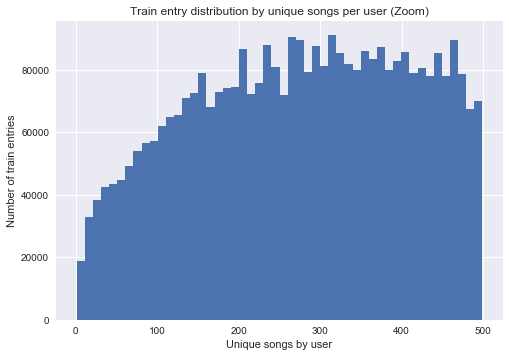

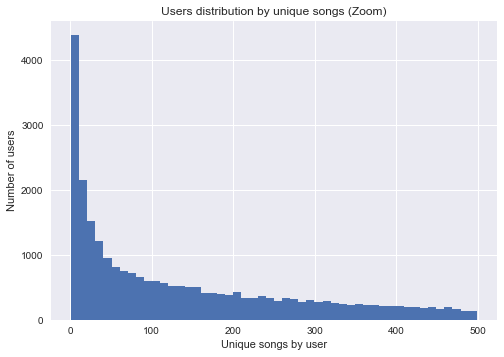

In [8]:
# Plot histogram of train entries by unique songs by user
plt.hist(train.song_count[train.song_count<500], bins=50)
plt.ylabel('Number of train entries')
plt.xlabel('Unique songs by user')
plt.title('Train entry distribution by unique songs per user (Zoom)')
plt.show()

# Plot histogram of users by number of unique songs
plt.hist(users_total_songs.song_count[users_total_songs.song_count<500], bins=50)
plt.ylabel('Number of users')
plt.xlabel('Unique songs by user')
plt.title('Users distribution by unique songs (Zoom)')
plt.show()

In [9]:
train_sample=train[train.song_count<=10]
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18738 entries, 609 to 7349075
Data columns (total 7 columns):
msno                  18738 non-null object
song_id               18738 non-null object
source_system_tab     18738 non-null object
source_screen_name    18738 non-null object
source_type           18738 non-null object
target                18738 non-null int64
song_count            18738 non-null int64
dtypes: int64(2), object(5)
memory usage: 1.1+ MB


In [10]:
train_sample=train[(train.song_count>=10) & (train.song_count<20)]
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31641 entries, 293 to 7346754
Data columns (total 7 columns):
msno                  31641 non-null object
song_id               31641 non-null object
source_system_tab     31641 non-null object
source_screen_name    31641 non-null object
source_type           31641 non-null object
target                31641 non-null int64
song_count            31641 non-null int64
dtypes: int64(2), object(5)
memory usage: 1.9+ MB


Although there are many users who have listened few songs, they don't represent a big proportion of the data. Also, we want to try to select a segment of the users that has more chances to appear both in the train and test data when we split the data. As the number of unique songs by user increases, there are less users falling under that criteria. We will segment users who have listen between 20 to 30 songs as a subsample. We consider this range is enough for users to be able to appear both in the test and train samples and at the same time is a good sample size.

In [11]:
train_sample=train[(train.song_count>=20) & (train.song_count<30)]
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37717 entries, 689 to 7347549
Data columns (total 7 columns):
msno                  37717 non-null object
song_id               37717 non-null object
source_system_tab     37717 non-null object
source_screen_name    37717 non-null object
source_type           37717 non-null object
target                37717 non-null int64
song_count            37717 non-null int64
dtypes: int64(2), object(5)
memory usage: 2.3+ MB


In [12]:
#Check amount of NaN in train.csv by column
train_sample.isnull().sum()

msno                  0
song_id               0
source_system_tab     0
source_screen_name    0
source_type           0
target                0
song_count            0
dtype: int64

In [13]:
# Generate dummy variables in members
train_dummies=pd.get_dummies(train_sample[['source_system_tab','source_screen_name','source_type']],drop_first=True)

# Concatenate dummy variables and target varibale
df_train=pd.concat([train_sample[['target','msno','song_id']], train_dummies],axis=1)
df_train.head()

# Define df
df=df_train

# Define matrix values (X) and outcome variable (y)
X=df.drop(['target','msno', 'song_id'],axis=1).values
y=df.target.values
features=df.columns.values[3:]
print(features)

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)

['source_system_tab_explore' 'source_system_tab_listen with'
 'source_system_tab_my library' 'source_system_tab_notification'
 'source_system_tab_radio' 'source_system_tab_search'
 'source_system_tab_settings' 'source_screen_name_album more'
 'source_screen_name_artist more' 'source_screen_name_concert'
 'source_screen_name_discover chart' 'source_screen_name_discover feature'
 'source_screen_name_discover genre' 'source_screen_name_discover new'
 'source_screen_name_explore' 'source_screen_name_local playlist more'
 'source_screen_name_my library' 'source_screen_name_my library_search'
 'source_screen_name_online playlist more'
 'source_screen_name_others profile more' 'source_screen_name_radio'
 'source_screen_name_search' 'source_screen_name_search home'
 'source_screen_name_search trends' 'source_screen_name_self profile more'
 'source_type_artist' 'source_type_listen-with' 'source_type_local-library'
 'source_type_local-playlist' 'source_type_my-daily-playlist'
 'source_type_onlin

In [14]:
def roc_curve_plot(model,X_test,y_test):

    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = model.predict_proba(X_test)[:,1]

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve', fontsize=18)
    plt.show()

In [15]:
def train_test_plot(model,parameter,parameter_label):
    # Extract train and test scores
    train_scores=model.cv_results_['mean_train_score']
    test_scores=model.cv_results_['mean_test_score']

    # Plot train and test scores versus parameter
    plt.plot(parameter,train_scores, 'o-')
    plt.plot(parameter,test_scores, 'o-')
    plt.title('Test vs. train scores', fontsize=18)
    plt.ylabel('Score', fontsize=14)
    plt.xlabel(parameter_label, fontsize=14)
    plt.legend(['Train','Test'])
    plt.show()    

In [16]:
def importances_plot(model,features):   
    # Extract feature importances of the best random forest
    importances=model.best_estimator_.feature_importances_

    # Extract indices 
    indices = np.argsort(importances)[::-1]

    # Plot feature importances
    plt.bar(range(len(features)), importances[indices])
    plt.xticks(range(len(features)), features[indices],rotation='vertical')
    plt.ylabel('Importance',fontsize=14)
    plt.title('Feature importances', fontsize=18)
    plt.show()

/Users/anavillalba/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/anavillalba/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/anavillalba/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/anavillalba/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/anavillalba/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:

{'logreg__C': 0.001}
Accuracy score:  0.664369034995
ROC-AUC score:  0.644828401165


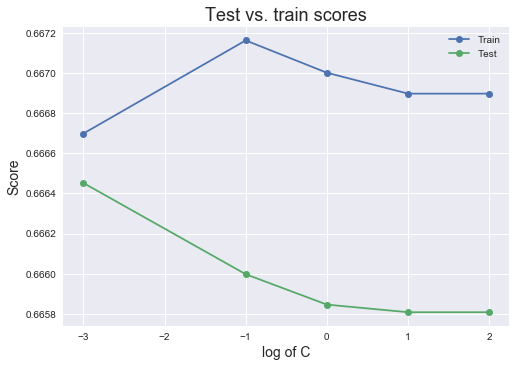

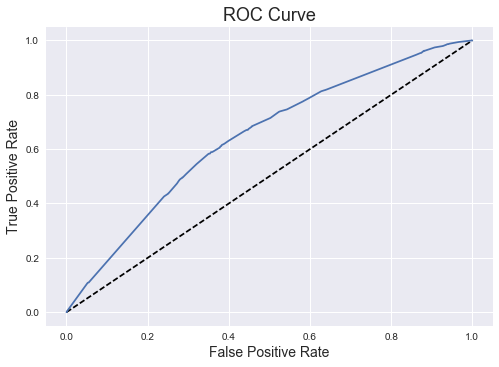

CPU times: user 19.7 s, sys: 545 ms, total: 20.2 s
Wall time: 5.82 s


In [17]:
%%time

# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('logreg', LogisticRegression())]

# Create the pipeline: pipeline
pipeline= Pipeline(steps)

# Setup the hyperparameter grid
Cs = [0.001, 0.1, 1, 10, 100]
param_grid = {'logreg__C': Cs}

# Create the Grid search object
logreg_cv=GridSearchCV(pipeline, param_grid, cv=5)

# Fit the model
logreg_cv.fit(X_train,y_train)

# Print best parameters
print(logreg_cv.best_params_)

# Compute accuracy and roc auc scores
accuracy_logreg_cv = accuracy_score(y_test,logreg_cv.predict(X_test))
roc_auc_logreg_cv= roc_auc_score(y_test,logreg_cv.predict_proba(X_test)[:,1])

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: ',accuracy_logreg_cv)
print('ROC-AUC score: ',roc_auc_logreg_cv)

# Plot train and test scores versus C parameter
train_test_plot(logreg_cv,np.log10(Cs),'log of C')

# Print roc curve
roc_curve_plot(logreg_cv,X_test,y_test)

/Users/anavillalba/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/anavillalba/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/anavillalba/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/anavillalba/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/anavillalba/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:

{'svm__C': 0.001}
Accuracy score:  0.664457405444
ROC-AUC score:  0.645571412565


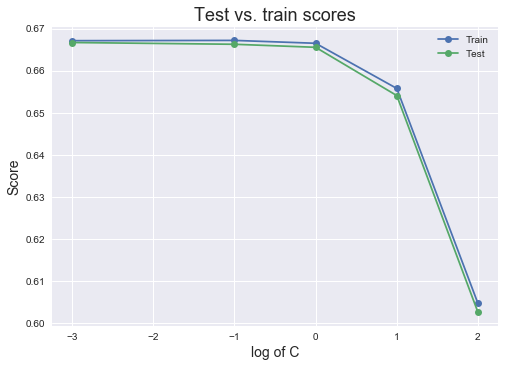

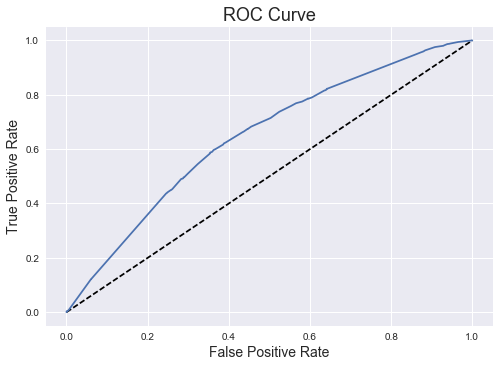

CPU times: user 1min 56s, sys: 1.33 s, total: 1min 58s
Wall time: 1min 43s


In [18]:
%%time

# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('svm', LinearSVC())]

# Setup the hyperparameter grid
Cs=[0.001, 0.1, 1, 10, 100]
param_grid = {'svm__C': Cs}

# Create the pipeline: pipeline
pipeline= Pipeline(steps)

# Create the Grid search object
svm_cv=GridSearchCV(pipeline, param_grid, cv=5)

# Fit the pipeline to the training set
svm_cv.fit(X_train,y_train)

# Print best parameters
print(svm_cv.best_params_)

# Compute accuracy and roc auc scores
accuracy_svm_cv = accuracy_score(y_test,svm_cv.predict(X_test))
roc_auc_svm_cv= roc_auc_score(y_test,svm_cv.decision_function(X_test))

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: ',accuracy_svm_cv)
print('ROC-AUC score: ',roc_auc_svm_cv)

# Plot train and test scores versus C parameter
train_test_plot(svm_cv,np.log10(Cs),'log of C')

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, svm_cv.decision_function(X_test))

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve', fontsize=18)
plt.show()

{'max_depth': 18}
Accuracy score:  0.667373630258
ROC-AUC score:  0.65414690765


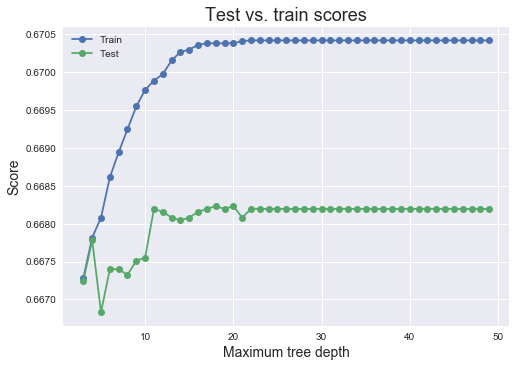

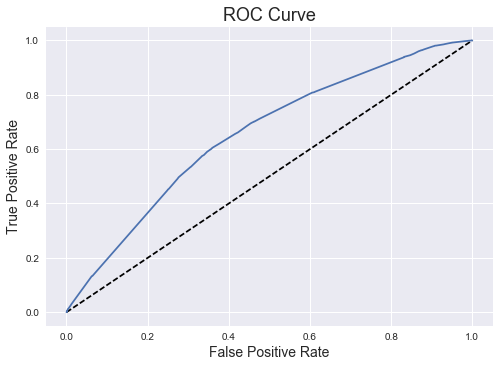

CPU times: user 7.89 s, sys: 89.4 ms, total: 7.98 s
Wall time: 8.06 s


In [19]:
%%time

# Instantiate model
tree = DecisionTreeClassifier(random_state=42)

max_depth=np.arange(3, 50)

# Setup the hyperparameter grid
param_grid = {'max_depth': max_depth}

# Create the Grid search object
tree_cv=GridSearchCV(tree, param_grid, cv=5)

# Train the model on training data
tree_cv.fit(X_train,y_train)

# Print best parameters
print(tree_cv.best_params_)

# Compute accuracy and roc auc scores
accuracy_tree_cv = accuracy_score(y_test,tree_cv.predict(X_test))
roc_auc_tree_cv= roc_auc_score(y_test,tree_cv.predict_proba(X_test)[:,1])

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: ',accuracy_tree_cv)
print('ROC-AUC score: ',roc_auc_tree_cv)

# Plot train and test scores versus C parameter
train_test_plot(tree_cv,max_depth,'Maximum tree depth')

# Print roc curve
roc_curve_plot(tree_cv,X_test,y_test)

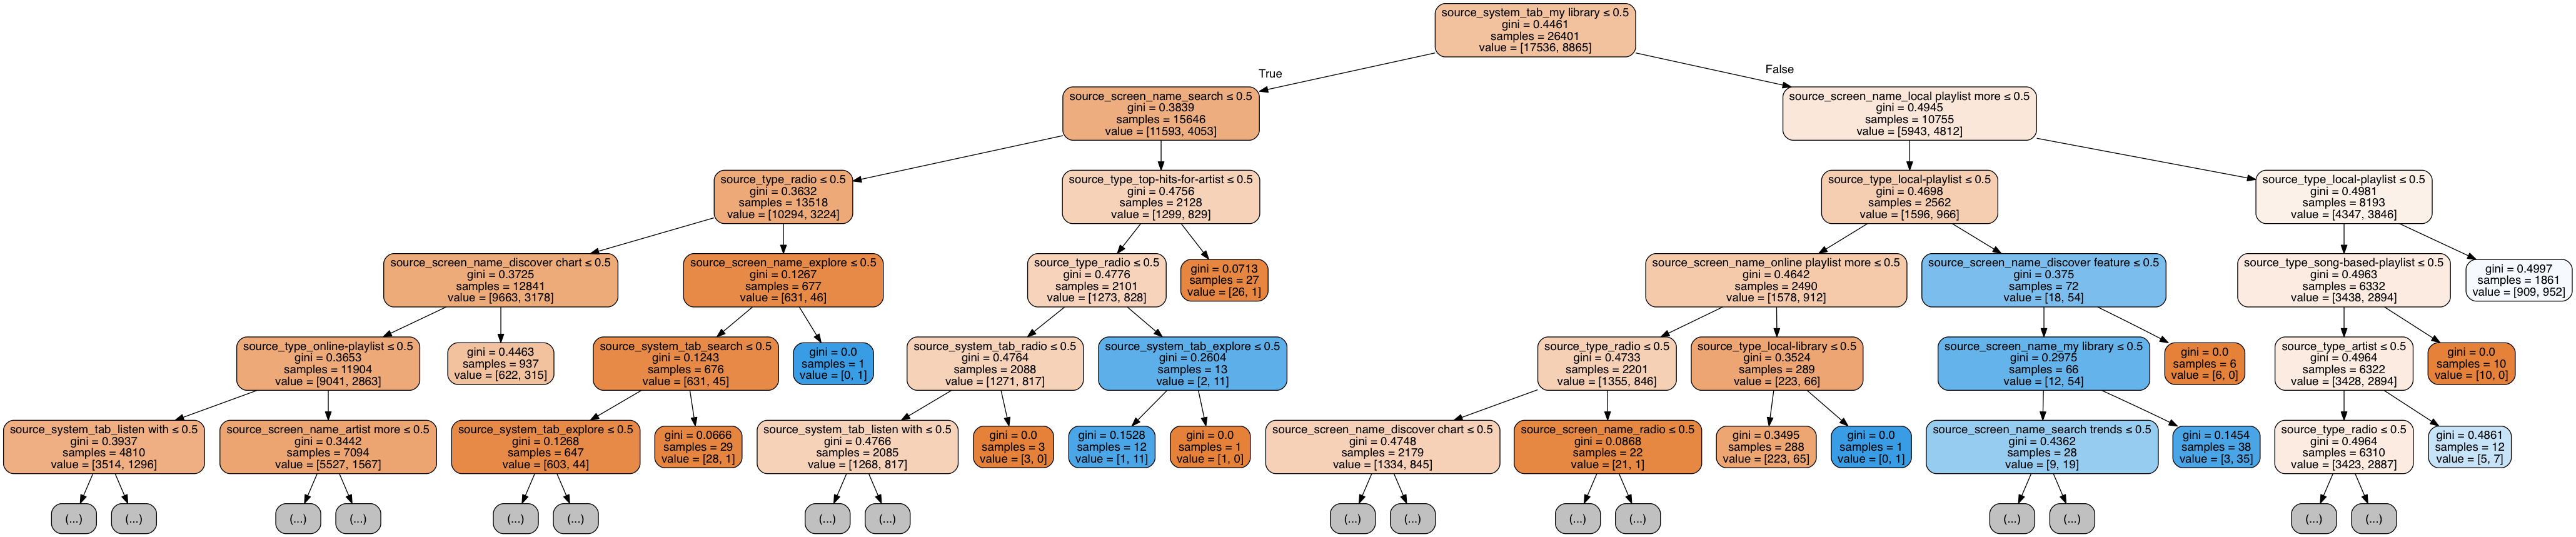

In [20]:
# Plot tree with best parameters
dot_data = StringIO()
export_graphviz(tree_cv.best_estimator_, out_file=dot_data,feature_names=features,  
                filled=True, rounded=True,
                special_characters=True, max_depth=5)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Based on the tree classifier, the most important features are source_system_tab_my_library, source_screen_name_local_playlist, source_type_local-playlist for the positive result (users playing again songs).

Other important features are source_screen_name_search, source_type_radio and source_type_top-hits-for-artist.

This is aligned what the results we observed in the exploratory initial analysis. We saw that the highest probabily of replaying a song was if it was played from tab my library and the worse if it was played from tab radio. We as well observed local playlist attributes to be revelant for the probabily of songs to be replayed. 

{'n_estimators': 12}
Accuracy score:  0.666578296218
ROC-AUC score:  0.654360434582


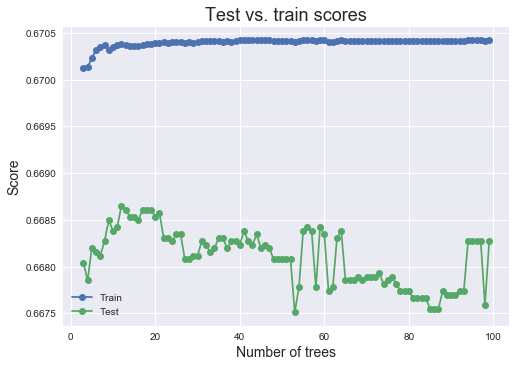

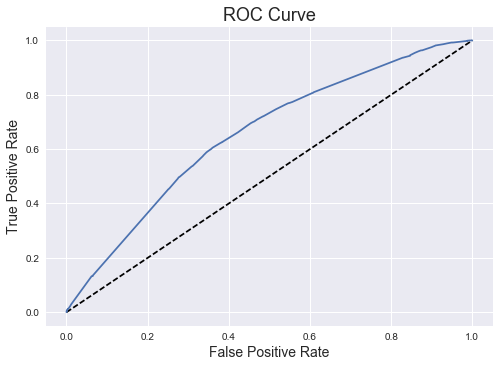

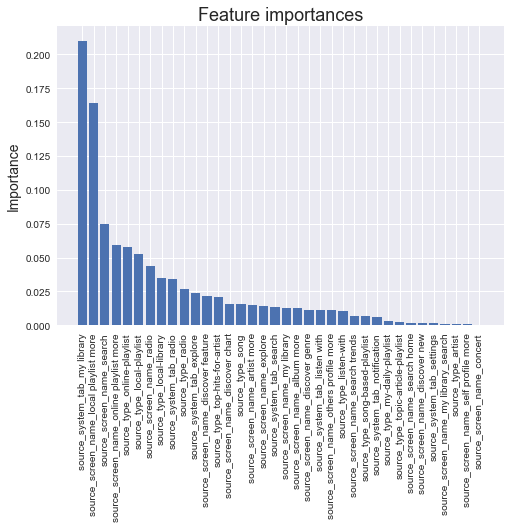

CPU times: user 5min 5s, sys: 5.57 s, total: 5min 10s
Wall time: 5min 12s


In [21]:
%%time

# Instantiate model
rf = RandomForestClassifier(max_features='sqrt', random_state = 42)

# Define n_estimators space
n_estimators=np.arange(3, 100)

# Setup the hyperparameter grid
param_grid = {'n_estimators': n_estimators}

# Create the Grid search object
rf_cv=GridSearchCV(rf, param_grid, cv=5)

# Train the model on training data
rf_cv.fit(X_train, y_train)

# Print best parameters
print(rf_cv.best_params_)

# Compute accuracy and roc auc scores
accuracy_rf_cv = accuracy_score(y_test,rf_cv.predict(X_test))
roc_auc_rf_cv= roc_auc_score(y_test,rf_cv.predict_proba(X_test)[:,1])

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: ',accuracy_rf_cv)
print('ROC-AUC score: ',roc_auc_rf_cv)

# Plot train and test scores versus n_estimators parameter
train_test_plot(rf_cv,n_estimators,'Number of trees')

# Print roc curve
roc_curve_plot(rf_cv,X_test,y_test)

# Print feature importances
importances_plot(rf_cv,features)

Based on the feature importance output of the random forest classifier and similar as we saw in the tree, the most important feature is the source_system_tab_my_library. We also saw in the tree that source_screen_name_local_playlist, source_screen_name_search and source_type_local-playlist were relevant. Other important features shown in the importances plot are source_screen_name_online_playlist_more and source_screen_name_radio.

{'max_features': 'sqrt', 'n_estimators': 50}
Accuracy score:  0.667020148462
ROC-AUC score:  0.654347374723


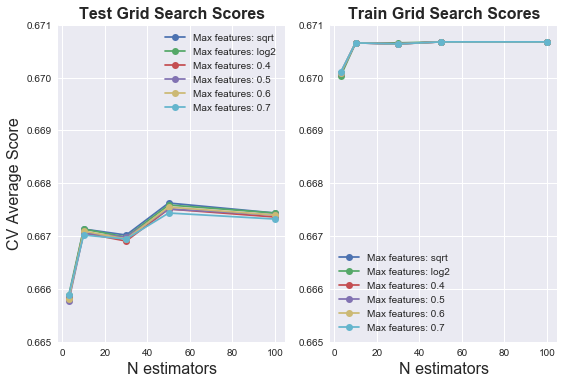

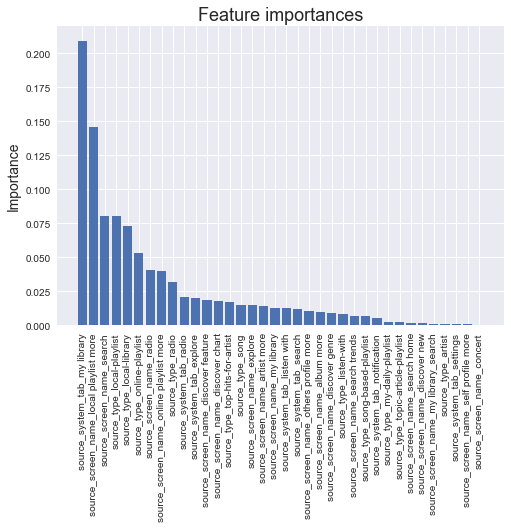

CPU times: user 48.8 s, sys: 1.07 s, total: 49.9 s
Wall time: 50.4 s


In [22]:
%%time

# Instantiate model
rf = RandomForestClassifier(random_state = 42)

# Define n_estimators space
n_estimators=[3,10,30,50,100]
max_features=['sqrt', 'log2', 0.4, 0.5, 0.6, 0.7]

# Setup the hyperparameter grid
param_grid = {'n_estimators': n_estimators, 'max_features': max_features}

# Create the Grid search object
rf_cv=GridSearchCV(rf, param_grid, cv=3)

# Train the model on training data
rf_cv.fit(X_train, y_train)

# Print best parameters
print(rf_cv.best_params_)

# Compute accuracy and roc auc scores
accuracy_rf_2_cv = accuracy_score(y_test,rf_cv.predict(X_test))
roc_auc_rf_2_cv= roc_auc_score(y_test,rf_cv.predict_proba(X_test)[:,1])

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: ',accuracy_rf_2_cv)
print('ROC-AUC score: ',roc_auc_rf_2_cv)

# Extract test and train scores
test_scores_mean = rf_cv.cv_results_['mean_test_score']
test_scores_mean = np.array(test_scores_mean).reshape(len(max_features),len(n_estimators))
train_scores_mean = rf_cv.cv_results_['mean_train_score']
train_scores_mean = np.array(train_scores_mean).reshape(len(max_features),len(n_estimators))

# Plot Grid search scores
_, (ax1,ax2) = plt.subplots(1,2)

# N_estimators is the X-axis, Max_features is represented as a different curve (color line)
for idx, val in enumerate(max_features):
    ax1.plot(n_estimators, test_scores_mean[idx,:], '-o', label= 'Max features' + ': ' + str(val))
    ax2.plot(n_estimators, train_scores_mean[idx,:], '-o', label= 'Max features' + ': ' + str(val))

ax1.set_title("Test Grid Search Scores", fontsize=16, fontweight='bold')
ax1.set_xlabel('N estimators', fontsize=16)
ax1.set_ylabel('CV Average Score', fontsize=16)
ax1.legend(loc="best", fontsize=10)
ax1.set_ylim(0.665,0.671)
ax2.set_title("Train Grid Search Scores", fontsize=16, fontweight='bold')
ax2.set_xlabel('N estimators', fontsize=16)
ax2.legend(loc="best", fontsize=10)
ax2.set_ylim(0.665,0.671)
_.tight_layout()
plt.show()

# Print feature importances
importances_plot(rf_cv,features)

In [23]:
d = {'Model': ['Logaritmic Regression', 'Linear SVM', 'Tree', 'Random Forest', 'Random Forest (more parameter iterations)'],
     'Accuracy': [accuracy_logreg_cv,accuracy_svm_cv,accuracy_tree_cv,accuracy_rf_cv,accuracy_rf_2_cv],
     'ROC AUC': [roc_auc_logreg_cv, roc_auc_svm_cv, roc_auc_tree_cv , roc_auc_rf_cv,roc_auc_rf_2_cv]}
print(pd.DataFrame(d)[['Model','Accuracy','ROC AUC']])

                                       Model  Accuracy   ROC AUC
0                      Logaritmic Regression  0.664369  0.644828
1                                 Linear SVM  0.664457  0.645571
2                                       Tree  0.667374  0.654147
3                              Random Forest  0.666578  0.654360
4  Random Forest (more parameter iterations)  0.667020  0.654347


### Including members features

- We are evaluating still the subsample with users who have listened between 20 and 30 different songs.
- We will now include more features to try to improve performance.

In [24]:
#Load members document
members=pd.read_csv('data/members_clean.csv', na_values='Unknown')
print(members.head())

# Fill gender Nan values with -1
members.gender=members.gender.fillna(-1)

# Fill missing age values with most frequent value
members.bd=members.bd.fillna(members.bd.value_counts().index[0])
    
# Transform to categorical variables
for item in ['city','gender','registered_via']:
    members[item]=members[item].astype('category')
    
for item in ['registration_init_time','expiration_date']:
    members[item]=pd.to_datetime(members[item],format='%Y-%m-%d')
    
# Compute new column days from registration to expiration
members['days_from_reg_to_exp']=members.apply(lambda row: (row.expiration_date - row.registration_init_time).days, axis=1)

# Compute new columns registration_year and expiration_year
members['registration_year']=members.apply(lambda row: row.registration_init_time.year, axis=1)
members['expiration_year']=members.apply(lambda row: row.expiration_date.year, axis=1)

# Print members head after parameter transformation
print(members.head())

                                           msno  city  bd gender  \
0  XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=     1 NaN    NaN   
1  UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=     1 NaN    NaN   
2  D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=     1 NaN    NaN   
3  mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=     1 NaN    NaN   
4  q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=     1 NaN    NaN   

   registered_via registration_init_time expiration_date  
0               7             2011-08-20      2017-09-20  
1               7             2015-06-28      2017-06-22  
2               4             2016-04-11      2017-07-12  
3               9             2015-09-06      2015-09-07  
4               4             2017-01-26      2017-06-13  
                                           msno city    bd gender  \
0  XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=    1  22.0     -1   
1  UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=    1  22.0     -1   
2  D8nEhsIOBSoE6VthTaqDX8U6lqj

In [25]:
#Check amount of NaN in members_clean.csv by column
members.info()

# Generate dummy variables in members
members_dummies=pd.get_dummies(members[['city','bd','gender','registered_via','days_from_reg_to_exp','registration_year','expiration_year']],drop_first=True)

# Join msno column and dummy variables in members
df_members=pd.concat([members.msno, members_dummies],axis=1)

# Join df_members with train data
df=df_train.merge(df_members, on='msno', how='left')

# Define matrix values (X) and outcome variable (y)
X=df.drop(['target','msno', 'song_id'],axis=1).values
y=df.target.values
features=df.columns.values[3:]

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34402 entries, 0 to 34401
Data columns (total 10 columns):
msno                      34402 non-null object
city                      34402 non-null category
bd                        34402 non-null float64
gender                    34402 non-null category
registered_via            34402 non-null category
registration_init_time    34402 non-null datetime64[ns]
expiration_date           34402 non-null datetime64[ns]
days_from_reg_to_exp      34402 non-null int64
registration_year         34402 non-null int64
expiration_year           34402 non-null int64
dtypes: category(3), datetime64[ns](2), float64(1), int64(3), object(1)
memory usage: 1.9+ MB


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37717 entries, 0 to 37716
Data columns (total 70 columns):
target                                     37717 non-null int64
msno                                       37717 non-null object
song_id                                    37717 non-null object
source_system_tab_explore                  37717 non-null uint8
source_system_tab_listen with              37717 non-null uint8
source_system_tab_my library               37717 non-null uint8
source_system_tab_notification             37717 non-null uint8
source_system_tab_radio                    37717 non-null uint8
source_system_tab_search                   37717 non-null uint8
source_system_tab_settings                 37717 non-null uint8
source_screen_name_album more              37717 non-null uint8
source_screen_name_artist more             37717 non-null uint8
source_screen_name_concert                 37717 non-null uint8
source_screen_name_discover chart          37717 non-null

In [27]:
X.shape

(37717, 67)

{'logreg__C': 0.001}
Accuracy score:  0.671173559562
ROC-AUC score:  0.659537320383


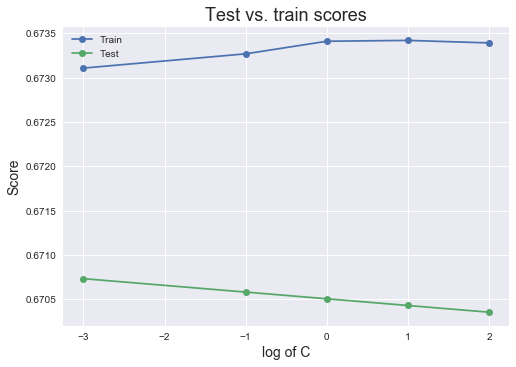

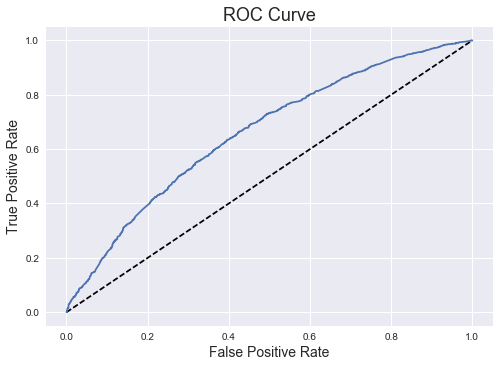

CPU times: user 28.5 s, sys: 826 ms, total: 29.3 s
Wall time: 13.1 s


In [28]:
%%time

# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('logreg', LogisticRegression())]

# Create the pipeline: pipeline
pipeline= Pipeline(steps)

# Setup the hyperparameter grid
Cs = [0.001, 0.1, 1, 10, 100]
param_grid = {'logreg__C': Cs}

# Create the Grid search object
logreg_cv=GridSearchCV(pipeline, param_grid, cv=5)

# Fit the model
logreg_cv.fit(X_train,y_train)

# Print best parameters
print(logreg_cv.best_params_)

# Compute accuracy and roc auc scores
accuracy_logreg_cv = accuracy_score(y_test,logreg_cv.predict(X_test))
roc_auc_logreg_cv= roc_auc_score(y_test,logreg_cv.predict_proba(X_test)[:,1])

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: ',accuracy_logreg_cv)
print('ROC-AUC score: ',roc_auc_logreg_cv)

# Plot train and test scores versus C parameter
train_test_plot(logreg_cv,np.log10(Cs),'log of C')

# Print roc curve
roc_curve_plot(logreg_cv,X_test,y_test)

{'svm__C': 0.001}
Accuracy score:  0.668434075645
ROC-AUC score:  0.658866015658


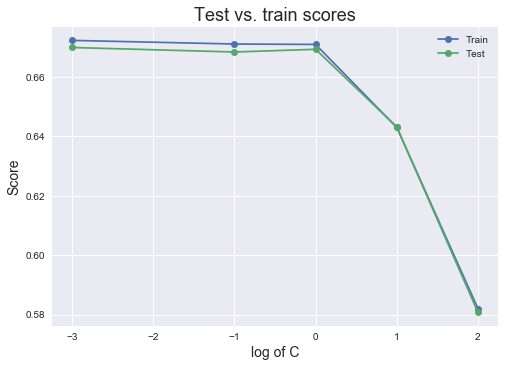

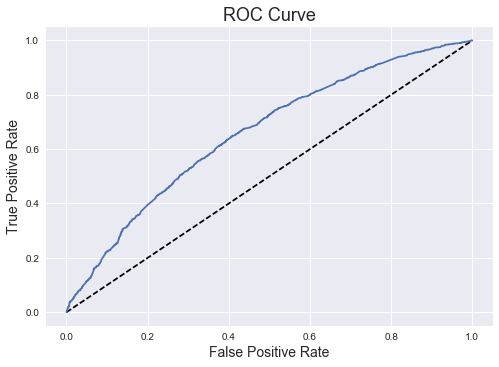

CPU times: user 2min 53s, sys: 1.51 s, total: 2min 54s
Wall time: 2min 39s


In [29]:
%%time

# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('svm', LinearSVC())]

# Setup the hyperparameter grid
Cs=[0.001, 0.1, 1, 10, 100]
param_grid = {'svm__C': Cs}

# Create the pipeline: pipeline
pipeline= Pipeline(steps)

# Create the Grid search object
svm_cv=GridSearchCV(pipeline, param_grid, cv=5)

# Fit the pipeline to the training set: svm_scaled
svm_cv.fit(X_train,y_train)

# Print best parameters
print(svm_cv.best_params_)

# Compute accuracy and roc auc scores
accuracy_svm_cv = accuracy_score(y_test,svm_cv.predict(X_test))
roc_auc_svm_cv= roc_auc_score(y_test,svm_cv.decision_function(X_test))

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: ',accuracy_svm_cv)
print('ROC-AUC score: ',roc_auc_svm_cv)

# Plot train and test scores versus C parameter
train_test_plot(svm_cv,np.log10(Cs),'log of C')

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, svm_cv.decision_function(X_test))

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve', fontsize=18)
plt.show()

{'max_depth': 33}
Accuracy score:  0.760516083422
ROC-AUC score:  0.788003434778


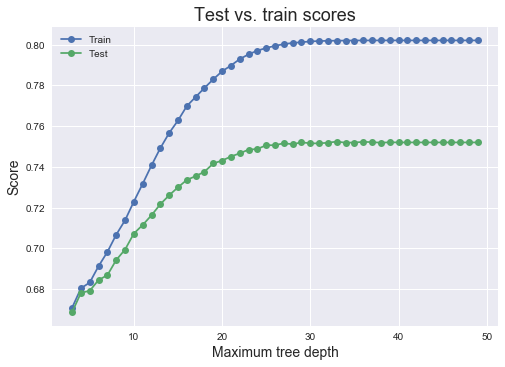

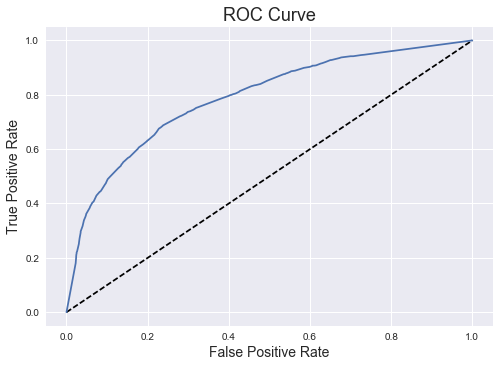

CPU times: user 27.5 s, sys: 615 ms, total: 28.1 s
Wall time: 28.2 s


In [30]:
%%time

# Instantiate model
tree = DecisionTreeClassifier(random_state=42)

max_depth=np.arange(3, 50)

# Setup the hyperparameter grid
param_grid = {'max_depth': max_depth}

# Create the Grid search object
tree_cv=GridSearchCV(tree, param_grid, cv=5)

# Train the model on training data
tree_cv.fit(X_train,y_train)

# Print best parameters
print(tree_cv.best_params_)

# Compute accuracy and roc auc scores
accuracy_tree_cv = accuracy_score(y_test,tree_cv.predict(X_test))
roc_auc_tree_cv= roc_auc_score(y_test,tree_cv.predict_proba(X_test)[:,1])

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: ',accuracy_tree_cv)
print('ROC-AUC score: ',roc_auc_tree_cv)

# Plot train and test scores versus C parameter
train_test_plot(tree_cv,max_depth,'Maximum tree depth')

# Print roc curve
roc_curve_plot(tree_cv,X_test,y_test)

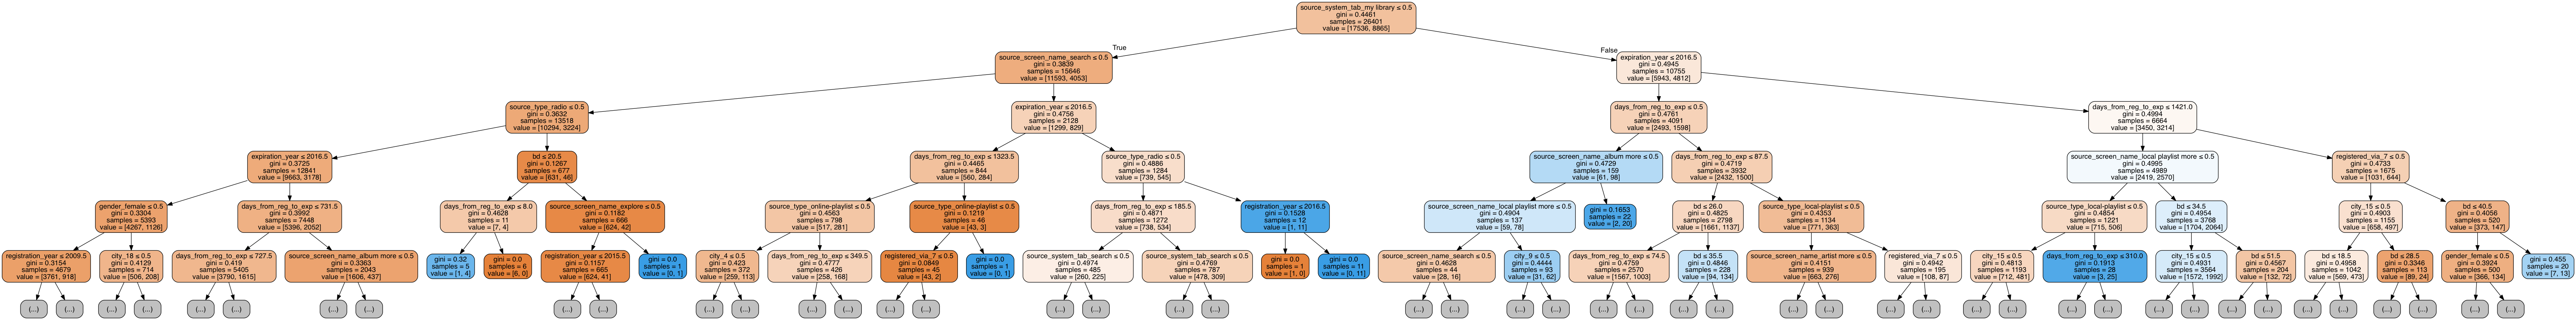

In [31]:
# Plot tree with best parameters
dot_data = StringIO()
export_graphviz(tree_cv.best_estimator_, out_file=dot_data,feature_names=features,  
                filled=True, rounded=True,
                special_characters=True, max_depth=5)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

After adding members information, we observed that not only source_tab_my_library, source_screen_name_search and source_type_radio are relevant. Expiration_year and days_from_reg_to_exp also seem very important features. And they actually help to improve the performance of the model.

{'n_estimators': 47}
Accuracy score:  0.761841640156
ROC-AUC score:  0.802130507549


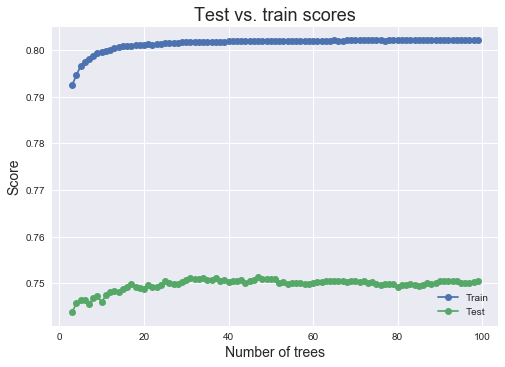

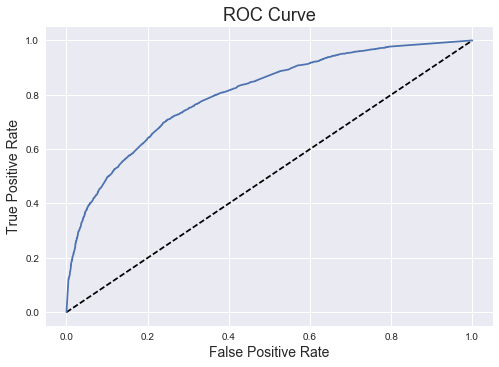

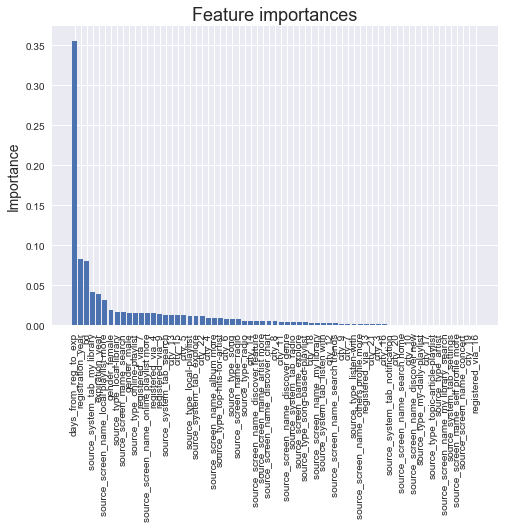

CPU times: user 11min 35s, sys: 17.5 s, total: 11min 52s
Wall time: 11min 56s


In [32]:
%%time

# Instantiate model
rf = RandomForestClassifier(max_features='sqrt', random_state = 42)

# Define n_estimators space
n_estimators=np.arange(3, 100)

# Setup the hyperparameter grid
param_grid = {'n_estimators': n_estimators}

# Create the Grid search object
rf_cv=GridSearchCV(rf, param_grid, cv=5)

# Train the model on training data
rf_cv.fit(X_train, y_train)

# Print best parameters
print(rf_cv.best_params_)

# Compute accuracy and roc auc scores
accuracy_rf_cv = accuracy_score(y_test,rf_cv.predict(X_test))
roc_auc_rf_cv= roc_auc_score(y_test,rf_cv.predict_proba(X_test)[:,1])

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: ',accuracy_rf_cv)
print('ROC-AUC score: ',roc_auc_rf_cv)

# Plot train and test scores versus n_estimators parameter
train_test_plot(rf_cv,n_estimators,'Number of trees')

# Print roc curve
roc_curve_plot(rf_cv,X_test,y_test)

# Print feature importances
importances_plot(rf_cv,features)

After including the members information, we observed in the tree that new features from members were very relevant. Although in the tree classifier source the most important feature was source_system_tab_my_library, in the random forest classifier the most relevant feature becomes days_from_reg_to_exp. Other features related to members, appart from the train features that we saw in the first analysis, are registration_year, age (bd), expiration_year or gender. 

{'max_features': 0.7, 'n_estimators': 50}
Accuracy score:  0.763255567338
ROC-AUC score:  0.803172215064


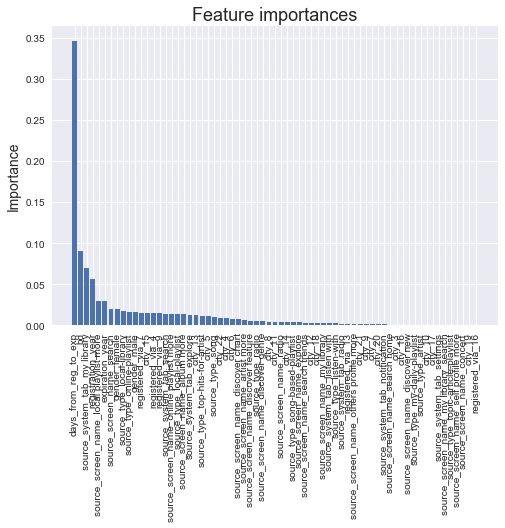

CPU times: user 2min 48s, sys: 3.11 s, total: 2min 51s
Wall time: 2min 52s


In [33]:
%%time

# Instantiate model
rf = RandomForestClassifier(random_state = 42)

# Define n_estimators space
n_estimators=[3,10,30,50,100]
max_features=['sqrt', 'log2', 0.4, 0.5, 0.6, 0.7, 0.8]

# Setup the hyperparameter grid
param_grid = {'n_estimators': n_estimators, 'max_features': max_features}

# Create the Grid search object
rf_cv=GridSearchCV(rf, param_grid, cv=3)

# Train the model on training data
rf_cv.fit(X_train, y_train)

# Print best parameters
print(rf_cv.best_params_)

# Compute accuracy and roc auc scores
accuracy_rf_2_cv = accuracy_score(y_test,rf_cv.predict(X_test))
roc_auc_rf_2_cv= roc_auc_score(y_test,rf_cv.predict_proba(X_test)[:,1])

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: ',accuracy_rf_2_cv)
print('ROC-AUC score: ',roc_auc_rf_2_cv)

# Print feature importances
importances_plot(rf_cv,features)

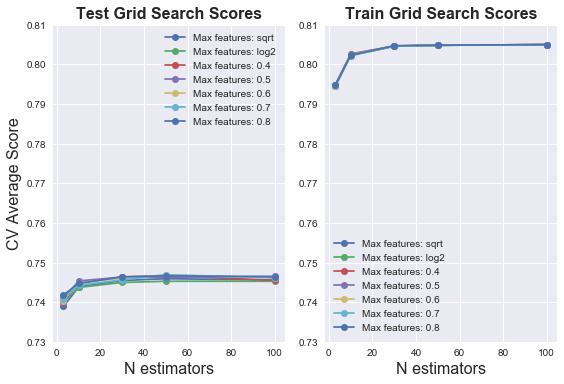

In [34]:
# Extract test and train scores
test_scores_mean = rf_cv.cv_results_['mean_test_score']
test_scores_mean = np.array(test_scores_mean).reshape(len(max_features),len(n_estimators))
train_scores_mean = rf_cv.cv_results_['mean_train_score']
train_scores_mean = np.array(train_scores_mean).reshape(len(max_features),len(n_estimators))

# Plot Grid search scores
_, (ax1,ax2) = plt.subplots(1,2)

# N_estimators is the X-axis, Max_features is represented as a different curve (color line)
for idx, val in enumerate(max_features):
    ax1.plot(n_estimators, test_scores_mean[idx,:], '-o', label= 'Max features' + ': ' + str(val))
    ax2.plot(n_estimators, train_scores_mean[idx,:], '-o', label= 'Max features' + ': ' + str(val))

# Set up graph attributes
ax1.set_title("Test Grid Search Scores", fontsize=16, fontweight='bold')
ax1.set_xlabel('N estimators', fontsize=16)
ax1.set_ylabel('CV Average Score', fontsize=16)
ax1.legend(loc="best", fontsize=10)
ax1.set_ylim(0.73,0.81)
ax2.set_title("Train Grid Search Scores", fontsize=16, fontweight='bold')
ax2.set_xlabel('N estimators', fontsize=16)
ax2.legend(loc="best", fontsize=10)
ax2.set_ylim(0.73,0.81)
_.tight_layout()
plt.show()

In [35]:
# Create dataframe with results from all models
d = {'Model': ['Logaritmic Regression', 'Linear SVM', 'Tree', 'Random Forest', 'Random Forest (more parameter iterations)'],
     'Accuracy': [accuracy_logreg_cv,accuracy_svm_cv,accuracy_tree_cv,accuracy_rf_cv,accuracy_rf_2_cv],
     'ROC AUC': [roc_auc_logreg_cv, roc_auc_svm_cv, roc_auc_tree_cv , roc_auc_rf_cv,roc_auc_rf_2_cv]}

# Plot results from all models
print(pd.DataFrame(d)[['Model','Accuracy','ROC AUC']])

                                       Model  Accuracy   ROC AUC
0                      Logaritmic Regression  0.671174  0.659537
1                                 Linear SVM  0.668434  0.658866
2                                       Tree  0.760516  0.788003
3                              Random Forest  0.761842  0.802131
4  Random Forest (more parameter iterations)  0.763256  0.803172


In the initial analysis only taking into account only train features, we did not see much difference in performace between the different methods. 

In this second analysis where we are also including member features, we are observing an improvement going from logistic regression (accuracy: 0.671) to tree classifier (accuracy: 0.761) and to random forest (accuracy: 0.763). 

### Including songs features

- We are evaluating still the subsample with users who have listened between 20 and 30 different songs.
- We will now include song features to try to improve performance.
- We will just do transformation on the songs that are within the subsample to reduce analysis complexity.
- We will just check tree and random forest classifiers since we saw in the previous analysis that the performance is better.

In [36]:
#Load train document
songs=pd.read_csv('data/songs_clean.csv', na_values='Unknown')
print(songs.head())

# We will just do transfo
song_sample=songs.merge(train_sample[['song_id']], on='song_id')

# Display info about the song_sample
song_sample.head()
song_sample.info()

                                        song_id  song_length_min genre_ids  \
0  CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=         4.127333   ['465']   
1  o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=         3.288800   ['444']   
2  DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=         3.863017   ['465']   
3  dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=         4.559233   ['465']   
4  W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=         2.338817   ['726']   

        artist_name                                  composer  \
0  張信哲 (Jeff Chang)                                    ['董貞']   
1         Blackpink  ['Teddy', 'Future Bounce', 'Bekuh Boom']   
2      Super Junior                                       NaN   
3             S.H.E                                   ['湯小康']   
4              貴族精選                           ['Traditional']   

          lyricist  language  genre_count  
0          ['何啟弘']         3          1.0  
1        ['Teddy']        31          1.0  
2       

In [37]:
# Replace Nan by list with -1
for item in ['genre_ids','composer','lyricist']:
    song_sample[item]=song_sample[item].apply(lambda x: literal_eval(x) if np.all(pd.notnull(x)) else ['-1'])
    
# Fill artist_name Nan values with -1
song_sample.artist_name=song_sample.artist_name.fillna(-1)

# Convert language into categorical variable
song_sample['language']=song_sample['language'].astype('category')

# Set up MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Get dummies for genre_ids and composer columns (separate items in list)
genre_ids_dummies=pd.DataFrame(mlb.fit_transform(song_sample.genre_ids),columns=mlb.classes_, index=song_sample.index)
composer_dummies=pd.DataFrame(mlb.fit_transform(song_sample.composer),columns=mlb.classes_, index=song_sample.index)

# Drop first column from genre_ids, composer and lyricist dummy variables
for item in [genre_ids_dummies,composer_dummies]:
    item = item.drop(item.columns[0],axis=1)

# Generate dummy variables in songs
songs_dummies=pd.get_dummies(song_sample[['song_length_min','language']],drop_first=True)

# Join song dummies, genre ids dummies and song id
df_songs=pd.concat([song_sample[['song_id']],songs_dummies, genre_ids_dummies],axis=1)

In [38]:
df_songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37717 entries, 0 to 37716
Data columns (total 98 columns):
song_id            37717 non-null object
song_length_min    37717 non-null float64
language_3         37717 non-null uint8
language_10        37717 non-null uint8
language_17        37717 non-null uint8
language_24        37717 non-null uint8
language_31        37717 non-null uint8
language_38        37717 non-null uint8
language_45        37717 non-null uint8
language_52        37717 non-null uint8
language_59        37717 non-null uint8
-1                 37717 non-null int64
1011               37717 non-null int64
1019               37717 non-null int64
1026               37717 non-null int64
1040               37717 non-null int64
1082               37717 non-null int64
109                37717 non-null int64
1096               37717 non-null int64
1138               37717 non-null int64
1152               37717 non-null int64
1155               37717 non-null int64
118     

In [39]:
df=df.merge(df_songs, on='song_id', how='left')
df.head()

target                                          msno  \
0       1  FTLG/3qKMWA3grsNYM70g2NI4Psyy6gZNCpBXxVX4l8=   
1       1  FTLG/3qKMWA3grsNYM70g2NI4Psyy6gZNCpBXxVX4l8=   
2       1  FTLG/3qKMWA3grsNYM70g2NI4Psyy6gZNCpBXxVX4l8=   
3       1  FTLG/3qKMWA3grsNYM70g2NI4Psyy6gZNCpBXxVX4l8=   
4       1  FTLG/3qKMWA3grsNYM70g2NI4Psyy6gZNCpBXxVX4l8=   

                                        song_id  source_system_tab_explore  \
0  KcQ4assZxaXsdizqxGjUSAY7CNc6+6hQzpVsjnWsShQ=                          0   
1  KcQ4assZxaXsdizqxGjUSAY7CNc6+6hQzpVsjnWsShQ=                          0   
2  KcQ4assZxaXsdizqxGjUSAY7CNc6+6hQzpVsjnWsShQ=                          0   
3  KcQ4assZxaXsdizqxGjUSAY7CNc6+6hQzpVsjnWsShQ=                          0   
4  KcQ4assZxaXsdizqxGjUSAY7CNc6+6hQzpVsjnWsShQ=                          0   

   source_system_tab_listen with  source_system_tab_my library  \
0                              0                             1   
1                              0                             1   
2                              0                             1   
3                              0                             1   
4                              0                             1   

   source_system_tab_notification  source_system_tab_radio  \
0                               0                        0   
1                               0                        0   
2                               0                        0   
3                               0                        0   
4                               0                        0   

   source_system_tab_search  source_system_tab_settings ...   880  893  900  \
0                         0                           0 ...     0    0    0   
1                         0                           0 ...     0    0    0   
2                         0                           0 ...     0    0    0   
3                         0                           0 ...     0    0    0   
4                         0                           0 ...     0    0    0   

   921  94  940  947  958  965  972  
0    0   0    0    0    0    0    0  
1    0   0    0    0    0    0    0  
2    0   0    0    0    0    0    0  
3    0   0    0    0    0    0    0  
4    0   0    0    0    0    0    0  

[5 rows x 167 columns]

In [40]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37717 entries, 0 to 1375964
Columns: 167 entries, target to 972
dtypes: float64(2), int64(91), object(2), uint8(72)
memory usage: 30.2+ MB


In [41]:
# Define matrix values (X) and outcome variable (y)
X=df.drop(['target','msno', 'song_id'],axis=1).values
y=df.target.values
features=df.columns.values[3:]

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)

In [42]:
X.shape

(37717, 164)

{'max_depth': 20}
Accuracy score:  0.723842347119
ROC-AUC score:  0.707195894373


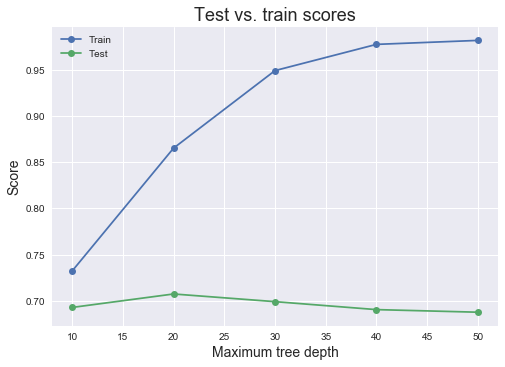

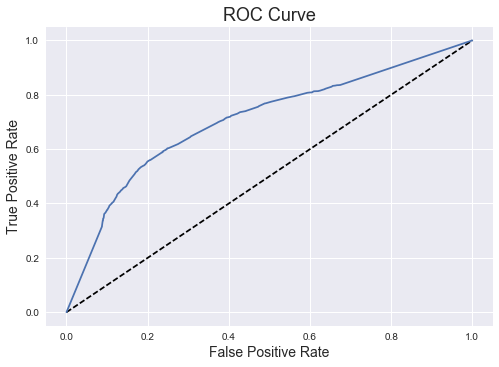

CPU times: user 5.68 s, sys: 184 ms, total: 5.87 s
Wall time: 5.89 s


In [43]:
%%time

# Instantiate model
tree = DecisionTreeClassifier(random_state=42)

max_depth=[10,20,30,40,50]

# Setup the hyperparameter grid
param_grid = {'max_depth': max_depth}

# Create the Grid search object
tree_cv=GridSearchCV(tree, param_grid, cv=3)

# Train the model on training data
tree_cv.fit(X_train,y_train)

# Print best parameters
print(tree_cv.best_params_)

# Compute accuracy and roc auc scores
accuracy_tree_cv = accuracy_score(y_test,tree_cv.predict(X_test))
roc_auc_tree_cv= roc_auc_score(y_test,tree_cv.predict_proba(X_test)[:,1])

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: ',accuracy_tree_cv)
print('ROC-AUC score: ',roc_auc_tree_cv)

# Plot train and test scores versus C parameter
train_test_plot(tree_cv,max_depth,'Maximum tree depth')

# Print roc curve
roc_curve_plot(tree_cv,X_test,y_test)

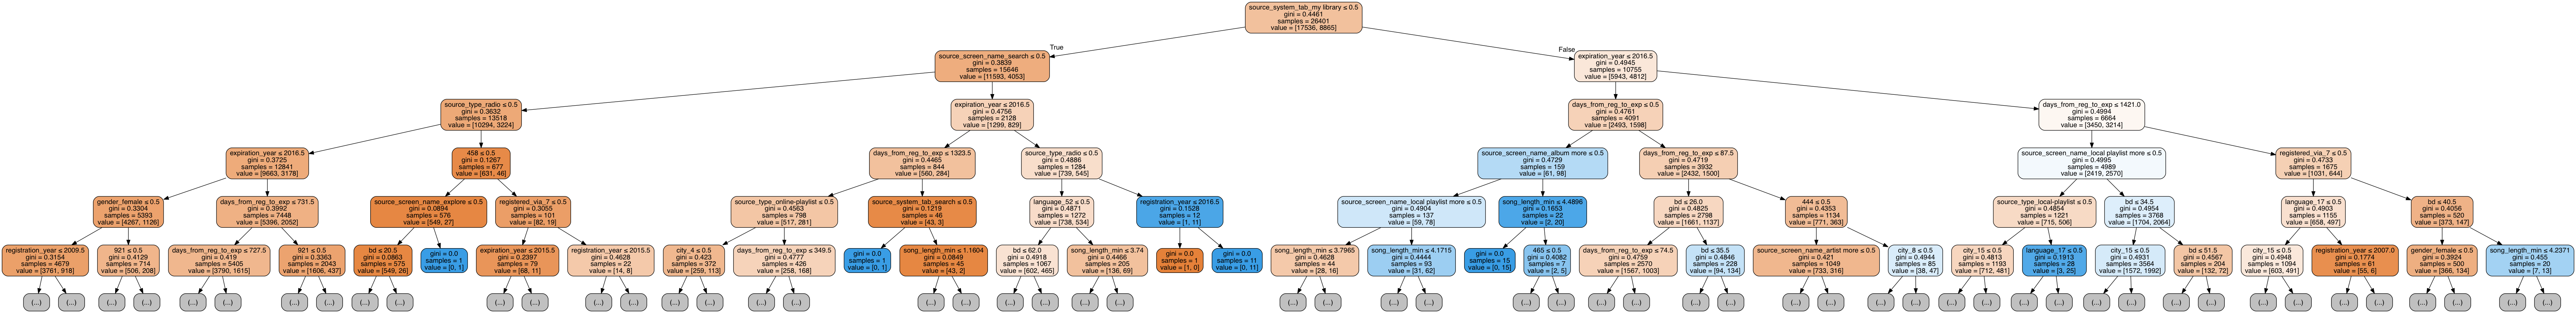

In [44]:
# Plot tree with best parameters
dot_data = StringIO()
export_graphviz(tree_cv.best_estimator_, out_file=dot_data,feature_names=features,  
                filled=True, rounded=True,
                special_characters=True, max_depth=5)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

{'n_estimators': 2000}
Accuracy score:  0.743018734535
ROC-AUC score:  0.770651417327


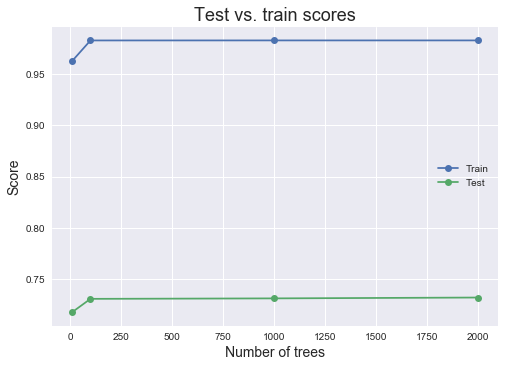

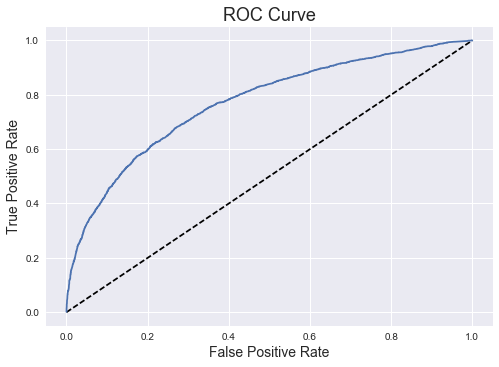

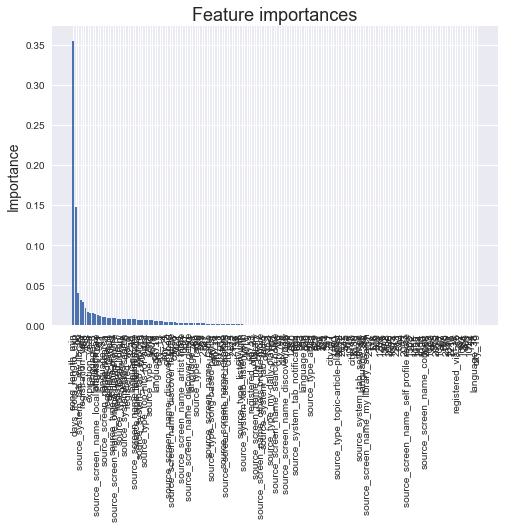

CPU times: user 30min 8s, sys: 10.3 s, total: 30min 19s
Wall time: 30min 30s


In [46]:
%%time

# Instantiate model
rf = RandomForestClassifier(max_features=0.7, random_state = 42)

# Define n_estimators space
n_estimators=[10,100,1000,2000]

# Setup the hyperparameter grid
param_grid = {'n_estimators': n_estimators}

# Create the Grid search object
rf_cv=GridSearchCV(rf, param_grid, cv=3)

# Train the model on training data
rf_cv.fit(X_train, y_train)

# Print best parameters
print(rf_cv.best_params_)

# Compute accuracy and roc auc scores
accuracy_rf_cv = accuracy_score(y_test,rf_cv.predict(X_test))
roc_auc_rf_cv= roc_auc_score(y_test,rf_cv.predict_proba(X_test)[:,1])

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: ',accuracy_rf_cv)
print('ROC-AUC score: ',roc_auc_rf_cv)

# Plot train and test scores versus n_estimators parameter
train_test_plot(rf_cv,n_estimators,'Number of trees')

# Print roc curve
roc_curve_plot(rf_cv,X_test,y_test)

# Print feature importances
importances_plot(rf_cv,features)

After adding songs information the most relevant feature in the random forest classifier becomes the length of the songs, but we observed that adding information about the songs did not improve the performace of the model.

In [47]:
ve the performace of the model, so d = {'Model': ['Tree', 'Random Forest'],
     'Accuracy': [accuracy_tree_cv,accuracy_rf_cv],
     'ROC AUC': [roc_auc_tree_cv , roc_auc_rf_cv]}
print(pd.DataFrame(d)[['Model','Accuracy','ROC AUC']])

           Model  Accuracy   ROC AUC
0           Tree  0.723842  0.707196
1  Random Forest  0.743019  0.770651


Adding information about the songs did not improve the performance of the model. We will try by doing dimension reduction with PCA to improve performance.

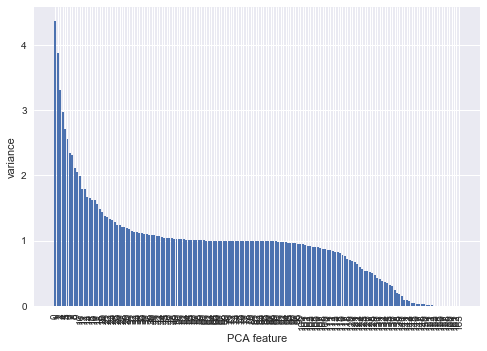

In [48]:
# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

# Fit the pipeline to 'samples'
pipeline.fit(X_train)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features,rotation=90)
plt.show()

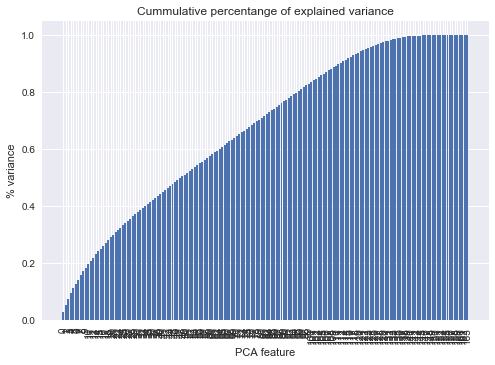

Number of features that explain 90% of the total variance:  112


In [49]:
# Create empty list for cummulative explained variance
cum_explained_variance=[]

# Compute total explained variance
total_variance=np.sum(pca.explained_variance_)

# Compute cummulative explained variance
for i in range(0,pca.n_components_):
    if i==0:
        cum_explained_variance.append(pca.explained_variance_[0])
    else:
        cum_explained_variance.append(cum_explained_variance[i-1]+pca.explained_variance_[i])

# Compute % of explained variance
per_explained_variance = cum_explained_variance / total_variance
        
# Plot explained variances
features = range(pca.n_components_)
plt.bar(features, per_explained_variance)
plt.xlabel('PCA feature')
plt.ylabel('% variance')
plt.title('Cummulative percentange of explained variance')
plt.xticks(features,rotation=90)
plt.show()

print('Number of features that explain 90% of the total variance: ',next(i for i, x in enumerate(per_explained_variance) if x >= 0.9))

In [50]:
# Build dataframe with explained variances
variance = pd.DataFrame({'Feature' : features,
 'Explained variance' : pca.explained_variance_})

# Print features with less than 0.5 of explained variance
variance[variance['Explained variance']<=0.5]

Explained variance  Feature
129        4.673707e-01      129
130        4.295649e-01      130
131        4.068295e-01      131
132        3.834949e-01      132
133        3.674906e-01      133
134        3.570922e-01      134
135        3.147455e-01      135
136        3.024846e-01      136
137        2.370256e-01      137
138        1.946344e-01      138
139        1.850838e-01      139
140        1.504721e-01      140
141        9.376171e-02      141
142        9.168065e-02      142
143        6.827511e-02      143
144        4.933115e-02      144
145        4.055483e-02      145
146        3.575407e-02      146
147        3.447211e-02      147
148        2.561886e-02      148
149        2.540247e-02      149
150        1.989766e-02      150
151        1.268706e-02      151
152        7.270122e-03      152
153        8.601535e-31      153
154        4.519174e-31      154
155        2.349157e-31      155
156        2.223808e-31      156
157        1.039670e-31      157
158        5.021095e-32      158
159        2.092776e-32      159
160        2.092776e-32      160
161        2.092776e-32      161
162        2.023006e-32      162
163        6.082063e-33      163

If we only want to consider features that explain more than 0.5 of variance, we should keep 128 features.

Accuracy score:  0.730470130788
ROC-AUC score:  0.75884642587


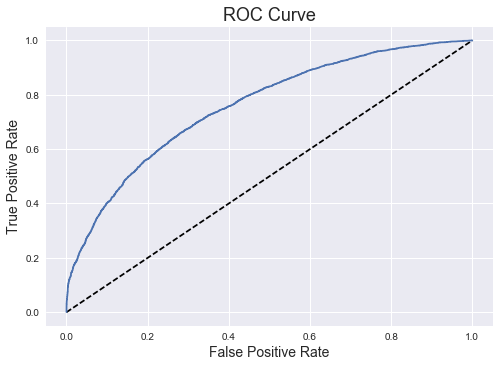

CPU times: user 47min 28s, sys: 7.75 s, total: 47min 36s
Wall time: 6min 33s


In [51]:
%%time

# Instantiate model
rf = RandomForestClassifier(n_estimators=1000, max_features=0.7, random_state = 42, n_jobs=-1)

# Create a PCA instance using number of features that explain 90% of the total variance
pca = PCA(n_components=93)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca,rf)

# Train the model on training data
pipeline.fit(X_train, y_train)

# Compute accuracy and roc auc scores
accuracy_rf = accuracy_score(y_test,pipeline.predict(X_test))
roc_auc_rf= roc_auc_score(y_test,pipeline.predict_proba(X_test)[:,1])

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: ',accuracy_rf)
print('ROC-AUC score: ',roc_auc_rf)

# Print roc curve
roc_curve_plot(pipeline,X_test,y_test)

Accuracy score:  0.718363379286
ROC-AUC score:  0.746936447859


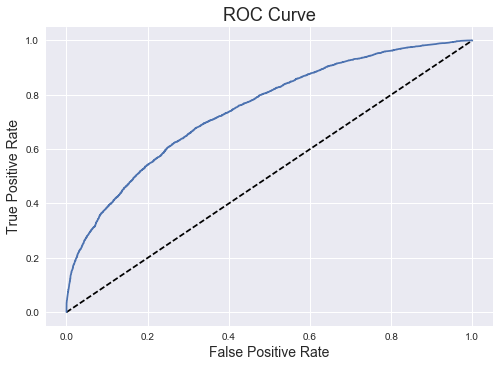

CPU times: user 1h 4min 42s, sys: 7.37 s, total: 1h 4min 49s
Wall time: 8min 37s


In [52]:
%%time

# Instantiate model
rf = RandomForestClassifier(n_estimators=1000, max_features=0.7, random_state = 42, n_jobs=-1)

# Create a PCA instance using number of features that explain more than 0.5 of variance
pca = PCA(n_components=128)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca,rf)

# Train the model on training data
pipeline.fit(X_train, y_train)

# Compute accuracy and roc auc scores
accuracy_rf = accuracy_score(y_test,pipeline.predict(X_test))
roc_auc_rf= roc_auc_score(y_test,pipeline.predict_proba(X_test)[:,1])

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: ',accuracy_rf)
print('ROC-AUC score: ',roc_auc_rf)

# Print roc curve
roc_curve_plot(pipeline,X_test,y_test)

{'pca__n_components': 80}
Accuracy score:  0.728260869565
ROC-AUC score:  0.75753599339


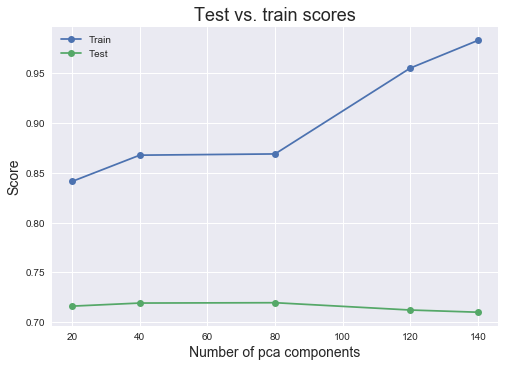

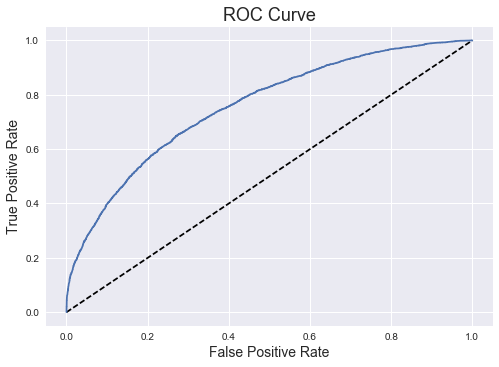

CPU times: user 6h 47min 54s, sys: 49.7 s, total: 6h 48min 43s
Wall time: 53min 53s


In [53]:
%%time

# Define parameter spaces
n_components=[20,40,80,120,140]

# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('pca', PCA()), ('rf',RandomForestClassifier(n_estimators=1000, max_features=0.7, random_state = 42, n_jobs=-1))]

# Create pipeline: pipeline
pipeline = Pipeline(steps)

# Setup the hyperparameter grid
params = {'pca__n_components': n_components}

# Create the Grid search object
rf_pipeline_cv = GridSearchCV(pipeline, params, cv=3)

# Train the model on training data
rf_pipeline_cv.fit(X_train, y_train)

# Print best parameters
print(rf_pipeline_cv.best_params_)

# Compute accuracy and roc auc scores
accuracy_rf_cv = accuracy_score(y_test,rf_pipeline_cv.predict(X_test))
roc_auc_rf_cv= roc_auc_score(y_test,rf_pipeline_cv.predict_proba(X_test)[:,1])

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: ',accuracy_rf_cv)
print('ROC-AUC score: ',roc_auc_rf_cv)

# Plot train and test scores versus n_estimators parameter
train_test_plot(rf_pipeline_cv,n_components,'Number of pca components')

# Print roc curve
roc_curve_plot(rf_pipeline_cv,X_test,y_test)

By adding some of the songs features to the model we did not improve performance. We tried to reduce the dimension of the model with PCA but that did not help either. We will now try to include less features from songs.

In [54]:
# Join df_members with train data
df=df_train.merge(df_members, on='msno', how='left')

#Select only language and song length
df_songs=pd.concat([song_sample[['song_id']],songs_dummies],axis=1)

# Join df_songs to df
df=df.merge(df_songs, on='song_id', how='left')
df.drop_duplicates(inplace=True)
df.head()

target                                          msno  \
0        1  FTLG/3qKMWA3grsNYM70g2NI4Psyy6gZNCpBXxVX4l8=   
13       1  FTLG/3qKMWA3grsNYM70g2NI4Psyy6gZNCpBXxVX4l8=   
14       1  FTLG/3qKMWA3grsNYM70g2NI4Psyy6gZNCpBXxVX4l8=   
36       1  FTLG/3qKMWA3grsNYM70g2NI4Psyy6gZNCpBXxVX4l8=   
37       0  FTLG/3qKMWA3grsNYM70g2NI4Psyy6gZNCpBXxVX4l8=   

                                         song_id  source_system_tab_explore  \
0   KcQ4assZxaXsdizqxGjUSAY7CNc6+6hQzpVsjnWsShQ=                          0   
13  GfbL6W9yNBIxkV48djUFBx4M3LGuTrM5yF+dkdA7JpM=                          0   
14  ayL6eLHKSrmX4smFi1KbGMYrWI9EwsiErGjWUJ9CTrQ=                          0   
36  /bjjSigCiXibQuiG7KH/EDw67OTu4R/2XM3UA9y5VfM=                          0   
37  d9Flpsyq/y8CR3F213pnXUkrfK1fMClvhYH37pFSc7s=                          0   

    source_system_tab_listen with  source_system_tab_my library  \
0                               0                             1   
13                              0                             1   
14                              0                             1   
36                              0                             1   
37                              0                             1   

    source_system_tab_notification  source_system_tab_radio  \
0                                0                        0   
13                               0                        0   
14                               0                        0   
36                               0                        0   
37                               0                        0   

    source_system_tab_search  source_system_tab_settings     ...       \
0                          0                           0     ...        
13                         0                           0     ...        
14                         0                           0     ...        
36                         0                           0     ...        
37                         0                           0     ...        

    song_length_min  language_3  language_10  language_17  language_24  \
0          4.127933           1            0            0            0   
13         4.881400           1            0            0            0   
14         4.465183           1            0            0            0   
36         3.469483           0            0            0            0   
37         4.924950           0            0            0            0   

    language_31  language_38  language_45  language_52  language_59  
0             0            0            0            0            0  
13            0            0            0            0            0  
14            0            0            0            0            0  
36            0            0            0            1            0  
37            0            0            0            1            0  

[5 rows x 80 columns]

In [55]:
# Define matrix values (X) and outcome variable (y)
X=df.drop(['target','msno', 'song_id'],axis=1).values
y=df.target.values

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)

{'n_estimators': 1000}
Accuracy score:  0.735065394132
ROC-AUC score:  0.761909715414


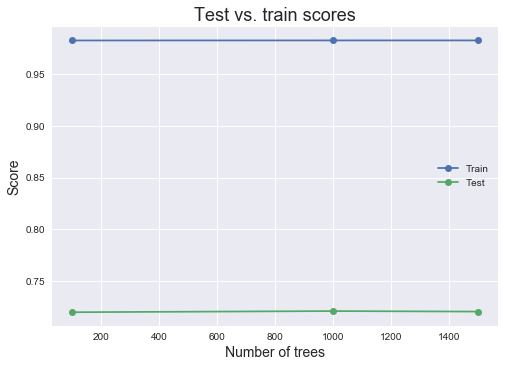

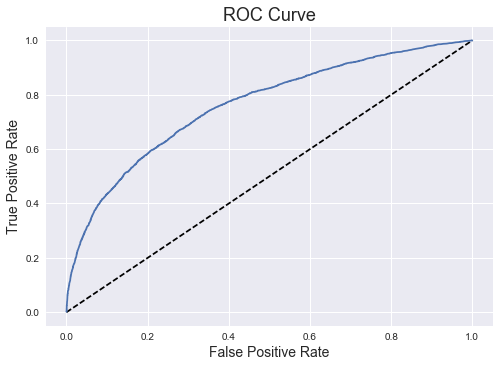

CPU times: user 11min 43s, sys: 5.79 s, total: 11min 49s
Wall time: 11min 49s


In [57]:
%%time

# Instantiate model
rf = RandomForestClassifier(max_features=0.7, random_state = 42)

# Define n_estimators space
n_estimators=[100,1000,1500]

# Setup the hyperparameter grid
param_grid = {'n_estimators': n_estimators}

# Create the Grid search object
rf_cv=GridSearchCV(rf, param_grid, cv=3)

# Train the model on training data
rf_cv.fit(X_train, y_train)

# Print best parameters
print(rf_cv.best_params_)

# Compute accuracy and roc auc scores
accuracy_rf_cv = accuracy_score(y_test,rf_cv.predict(X_test))
roc_auc_rf_cv= roc_auc_score(y_test,rf_cv.predict_proba(X_test)[:,1])

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: ',accuracy_rf_cv)
print('ROC-AUC score: ',roc_auc_rf_cv)

# Plot train and test scores versus n_estimators parameter
train_test_plot(rf_cv,n_estimators,'Number of trees')

# Print roc curve
roc_curve_plot(rf_cv,X_test,y_test)


In [58]:
%%time

# Instantiate model
rf = RandomForestClassifier(random_state = 42)

# Define n_estimators space
n_estimators=[3,10,30,50,100]
max_features=['sqrt', 'log2', 0.4, 0.5, 0.6, 0.7, 0.8]

# Setup the hyperparameter grid
param_grid = {'n_estimators': n_estimators, 'max_features': max_features}

# Create the Grid search object
rf_cv=GridSearchCV(rf, param_grid, cv=3)

# Train the model on training data
rf_cv.fit(X_train, y_train)

# Print best parameters
print(rf_cv.best_params_)

# Compute accuracy and roc auc scores
accuracy_rf_2_cv = accuracy_score(y_test,rf_cv.predict(X_test))
roc_auc_rf_2_cv= roc_auc_score(y_test,rf_cv.predict_proba(X_test)[:,1])

# Print the accuracy and roc auc scores of the testing data
print('Accuracy score: ',accuracy_rf_2_cv)
print('ROC-AUC score: ',roc_auc_rf_2_cv)


{'max_features': 0.5, 'n_estimators': 100}
Accuracy score:  0.734004948745
ROC-AUC score:  0.761343484776
CPU times: user 3min 55s, sys: 3.61 s, total: 3min 59s
Wall time: 3min 59s


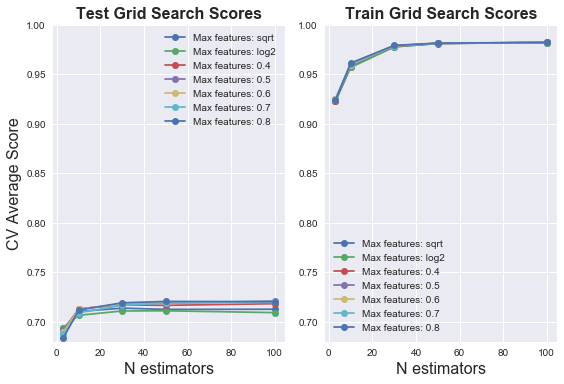

In [59]:
# Extract test and train scores
test_scores_mean = rf_cv.cv_results_['mean_test_score']
test_scores_mean = np.array(test_scores_mean).reshape(len(max_features),len(n_estimators))
train_scores_mean = rf_cv.cv_results_['mean_train_score']
train_scores_mean = np.array(train_scores_mean).reshape(len(max_features),len(n_estimators))

# Plot Grid search scores
_, (ax1,ax2) = plt.subplots(1,2)

# N_estimators is the X-axis, Max_features is represented as a different curve (color line)
for idx, val in enumerate(max_features):
    ax1.plot(n_estimators, test_scores_mean[idx,:], '-o', label= 'Max features' + ': ' + str(val))
    ax2.plot(n_estimators, train_scores_mean[idx,:], '-o', label= 'Max features' + ': ' + str(val))

# Set up graph attributes
ax1.set_title("Test Grid Search Scores", fontsize=16, fontweight='bold')
ax1.set_xlabel('N estimators', fontsize=16)
ax1.set_ylabel('CV Average Score', fontsize=16)
ax1.legend(loc="best", fontsize=10)
ax1.set_ylim(0.68,1)
ax2.set_title("Train Grid Search Scores", fontsize=16, fontweight='bold')
ax2.set_xlabel('N estimators', fontsize=16)
ax2.legend(loc="best", fontsize=10)
ax2.set_ylim(0.68,1)
_.tight_layout()
plt.show()

Considering less song features did not improve performance. From all the analysis we tried, the best one is considering train and members data. 

The best model is random forest with the following parameters: {'max_features': 0.7, 'n_estimators': 50}
- Accuracy score:  0.763255567338
- ROC-AUC score:  0.803172215064 